In [1]:
import numpy as np
import scipy.special as sp

### Definitions of relevant functions

In [2]:
def hilbert_gaussian(zeta):
    return 2.0 / np.sqrt(np.pi) * sp.dawsn(zeta)

def hilbert_gaussian_derivative(zeta):
    return 2.0 / np.sqrt(np.pi) * (1.0 - 2.0 * zeta * sp.dawsn(zeta))

In [3]:
def f_plus(zeta):
    return (np.exp(-zeta**2.0) + 1j * hilbert_gaussian(zeta)) / 2.0

def f_minus(zeta):
    return (np.exp(-zeta**2.0) - 1j * hilbert_gaussian(zeta)) / 2.0

def F(zeta):
    return -2.0*zeta*np.exp(-zeta**2.0)

def F_plus(zeta):
    return (F(zeta) + 1j * hilbert_gaussian_derivative(zeta)) / 2.0

def F_minus(zeta):
    return (F(zeta) - 1j * hilbert_gaussian_derivative(zeta)) / 2.0

### Test above functions

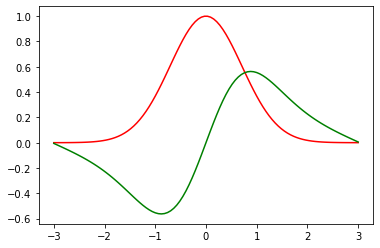

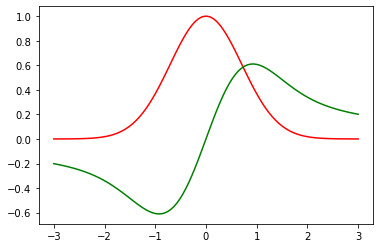

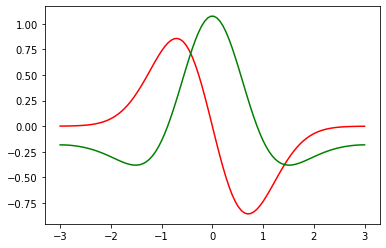

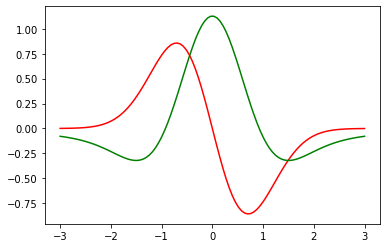

In [4]:
import matplotlib.pyplot as plt
import scipy.signal as sg

x = np.linspace(-3, 3, num=100)
gauss = np.exp(-x**2.0)
hilb_gauss = np.imag(sg.hilbert(gauss))

plt.figure()
plt.plot(x, gauss, 'r')
plt.plot(x, hilb_gauss, 'g')

hilb_gauss = hilbert_gaussian(x)
plt.figure()
plt.plot(x, gauss, 'r')
plt.plot(x, hilb_gauss, 'g')

gauss_deriv = -2.0 * x * np.exp(-x**2.0)
hilb_gauss_deriv = np.imag(sg.hilbert(gauss_deriv))
func_hilb_gauss_deriv = hilbert_gaussian_derivative(x)

plt.figure()
plt.plot(x, gauss_deriv, 'r')
plt.plot(x, hilb_gauss_deriv, 'g')

plt.figure()
plt.plot(x, gauss_deriv, 'r')
plt.plot(x, func_hilb_gauss_deriv, 'g')
plt.show()

In [5]:
# Complex plane
x = np.linspace(-5, 5, num=100)
y = np.linspace(-5, 5, num=100)
X, Y = np.tensordot(x, np.ones_like(y), axes=0), np.tensordot(np.ones_like(x), y, axes=0)
ZZ = X + 1j * Y

### The positive and negative frequency parts of the perturbation np.exp(-v^2)


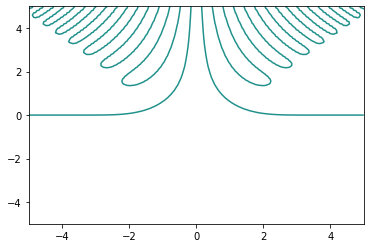

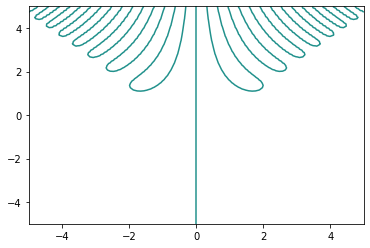

In [6]:
fp = f_plus(ZZ)
fm = f_minus(ZZ)

fpr, fpi = np.real(fp), np.imag(fp)
fmr, fmi = np.real(fm), np.imag(fm)

def cb(f):
    return np.linspace(np.amin(f), np.amax(f), num=100)

plt.figure()
plt.contour(X, Y, fmr, 0)

plt.figure()
plt.contour(X, Y, fmi, 0)

plt.show()

### The positive and negative frequency parts of background F = d/dv(e^(-z^2))

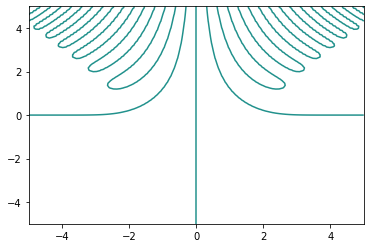

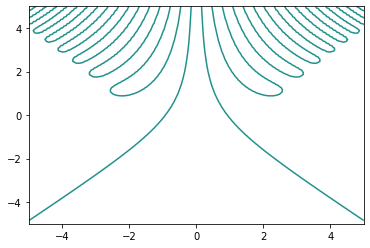

In [7]:
Fp = F_plus(ZZ)
Fm = F_minus(ZZ)

Fpr, Fpi = np.real(Fp), np.imag(Fp)
Fmr, Fmi = np.real(Fm), np.imag(Fm)

plt.figure()
plt.contour(X, Y, Fmr, 0)

plt.figure()
plt.contour(X, Y, Fmi, 0)

plt.show()

### The van Kampen spectrum of the Gaussian perturbation

In [8]:
def C_plus(f_plus, F_plus):
    return f_plus / (1.0 + 2.0j * np.pi * F_plus)

def C_minus(f_minus, F_minus):
    return f_minus / (1.0 - 2.0j * np.pi * F_minus)

def C(f_plus, F_plus, f_minus, F_minus):
    return C_plus(f_plus, F_plus) + C_minus(f_minus, F_minus)

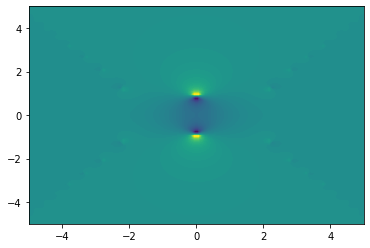

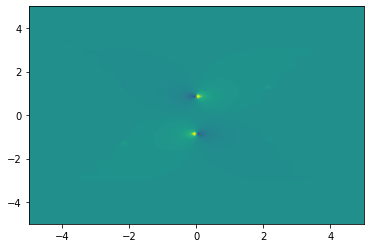

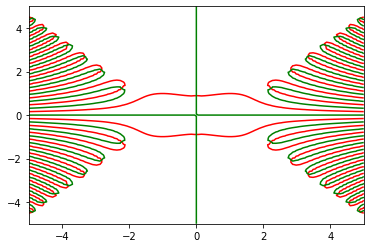

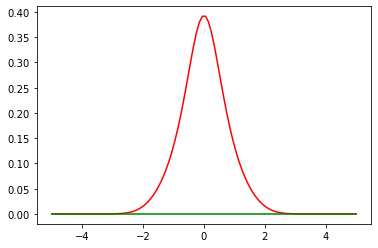

In [17]:
C_gaussian = C(fp, Fp, fm, Fm)

Cr, Ci = np.real(C_gaussian), np.imag(C_gaussian)

plt.figure()
plt.contourf(X, Y, Cr, cb(Cr))

plt.figure()
plt.contourf(X, Y, Ci, cb(Ci))

plt.figure()
plt.contour(X, Y, Cr, 0, colors='r'), plt.contour(X, Y, Ci, 0, colors='g')

plt.figure()
CxF = -C(f_plus(x), F_plus(x), f_minus(x), F_minus(x))  # * F(x)
plt.plot(x, np.real(CxF), 'r')
plt.plot(x, np.imag(CxF), 'g')

plt.show()

### Reconstruction of the Gaussian: inverting the van Kampen spectrum

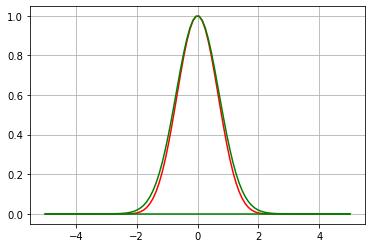

In [46]:
# The "residue" (sort-of)
def residue(x):
    fpx, fmx, Fpx, Fmx = f_plus(x), f_minus(x), F_plus(x), F_minus(x)
    F_star = Fpx - Fmx
    return (1.0 + 1j * np.pi * F_star) * C(fpx, Fpx, fmx, Fmx) / F(x)

# Re-evaluate C with only real values
# def integrand(x, v):
#     return C(f_plus(x), F_plus(x), f_minus(x), F_minus(x)) * F(x) / (x - v)
# def integrand_real(x, v):
#     return np.real(integrand(x, v))
# def integrand_imag(x, v):
#     return np.imag(integrand(x, v))
def integrand(x):
    return -C(f_plus(x), F_plus(x), f_minus(x), F_minus(x))  # * F(x)  # / (x - v)
def integrand_real(x):
    return np.real(integrand(x))
def integrand_imag(x):
    return np.imag(integrand(x))


from scipy import integrate
def principal_value(v):
    out = np.zeros_like(v) + 0j
    for i in range(v.shape[0]):
        out[i] = (integrate.quad(integrand_real, -20, 20, weight='cauchy', wvar=v[i])[0] +
                  1j * integrate.quad(integrand_imag, -20, 20, weight='cauchy', wvar=v[i])[0])
    return out

inverse = (principal_value(x) + residue(x)) * F(x)

plt.figure()
plt.plot(x, np.real(inverse), 'r')
# plt.plot(x, np.imag(inverse), 'g')  # Turns out it's identically zero
plt.plot(x, np.exp(-x**2.0), 'g')
plt.grid(True)
plt.show()

# Yes, the transformation is invertible! Summary:
### Let $\zeta = \frac{\omega}{k}$ be the phase velocity,
### $\zeta_p = \frac{\omega_p}{k}$ be the plasma phase velocity
### $F(v) = \frac{\partial f_0}{\partial v}$ be the background distribution gradient
### The eigenfunction is given by:
# $g(k, \zeta, v) = \zeta_p^2F(v)\Big[\mathcal{P}\frac{1}{\zeta-v} + \lambda(k,\zeta)\delta(\zeta - v)\Big]$
##### These eigenfunctions have a continuous spectrum in $(k,\zeta)$, each with an associated eigenvalue $\lambda(k,\zeta)$.
### The eigenvalues satisfy the modified dispersion relation
# $\mathcal{P}\int_{-\infty}^\infty\frac{F(v)}{\zeta-v}dv + \lambda(k,\omega)F(v) = \zeta_p^{-2}$
##### Therefore, the spectrum depends on the background distribution function's gradient
##### Note that the special values $\lambda = \pm i\pi$ correspond to the Landau modes in the limit of small damping
### The solution of the integral equation for $\lambda(k,\zeta)$ is found as follows
### 1) Consider the expansion of the perturbation in the van Kampen modes:
# $f_1(z,v,t) = \int_{-\infty}^\infty\int_{-\infty}^\infty C(k,\zeta)g(k,\zeta,v)e^{ik(z-\zeta t)}dkd\zeta$
### in terms of the perturbation's continuous spectrum $C(k,\zeta)$.
### 2) Consider $t=0$ and Fourier transform the above equation, reducing to
# $f_1(k,v) = \int_{-\infty}^\infty C(k,\zeta)g(k,\zeta,v)d\zeta$
### 3) Integrate out the eigenfunctions $g(k,\zeta,v)$ for the form of the perturbation
# $f_1(v) = \zeta_p^2F(v)\Big[\mathcal{P}\int_{-\infty}^\infty\frac{C(\zeta)}{\zeta-v}dv + \lambda(v)C(v)\Big]$
### 4) Solve this singular integral equation using the Hilbert transformation
##### Background info:
##### Define the Hilbert transform $G^*(\zeta) = \frac{1}{i\pi}\mathcal{P}\int_{-\infty}^\infty \frac{G(v)}{v-\zeta}dv$
##### Split the function $G(\zeta)$ into its positive and negative frequency components, $G(v) = G^+ + G^-$
##### The Hilbert transform has the property that $G^* = G^+ - G^-$
##### Therefore, $G^+ = \frac{1}{2}(G + G^*)$ and $G^- = \frac{1}{2}(G - G^*)$
##### The functions $G^+$ and $G^-$ are determined by the Hilbert transform of $G$.
##### Determining the $G^*$ given functions $G^+$ and $G^-$ for $x\in\mathbb{R}$ is called solving the Riemann-Hilbert problem. So, this procedure is backwards from "solving the Riemann-Hilbert problem" because often we'll simply be able to calculate the Hilbert transform. If it's too hard to calculate, then one can solve the Riemann-Hilbert problem associated with $G$ instead.
#### The solution for $C(\zeta)$ is simply
# $C(\zeta) = \frac{f_1^+(\zeta)}{1 + 2\pi i \zeta_p^2 F+^(\zeta)} + \frac{f_1^-(\zeta)}{1 + 2\pi i \zeta_p^2 F^-(\zeta)}$
##### Therefore, to determine the van Kampen spectrum, find the Hilbert transforms of both $f_1(v)$ and $F(v)$.